# Playground

In [99]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("./code")

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader

from dataset import *
from plots import *

## Metadata Summary

In [101]:
metadata = load_metadata()

In [102]:
metadata.head()

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moa
0,0,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
1,1,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
2,2,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,2,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
3,3,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,3,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
4,4,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,4,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO


In [103]:
metadata.shape

(488396, 19)

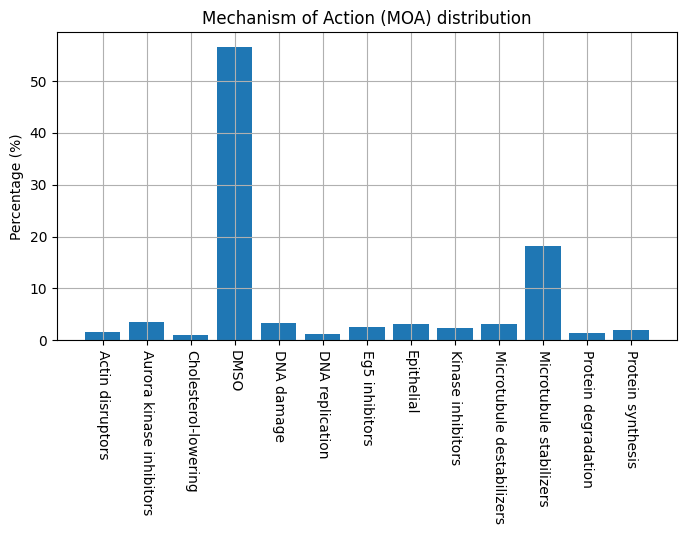

In [115]:
plot_MOA_distribution(metadata)

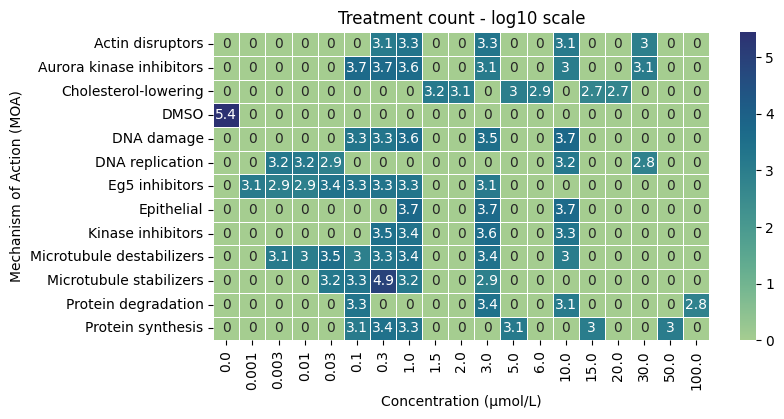

In [105]:
plot_treatment_heatmap(metadata)

## Tiny - Subset of Dataset

In [106]:
tiny_metadata = metadata[metadata["Multi_Cell_Image_Name"] == "Week10_200907_F02_s1_w14631241C-4FA2-4BC9-8693-D7D268CAEE82"]
images = load_images_from_metadata(tiny_metadata)
print("{} images".format(images.shape[0]))

40 images


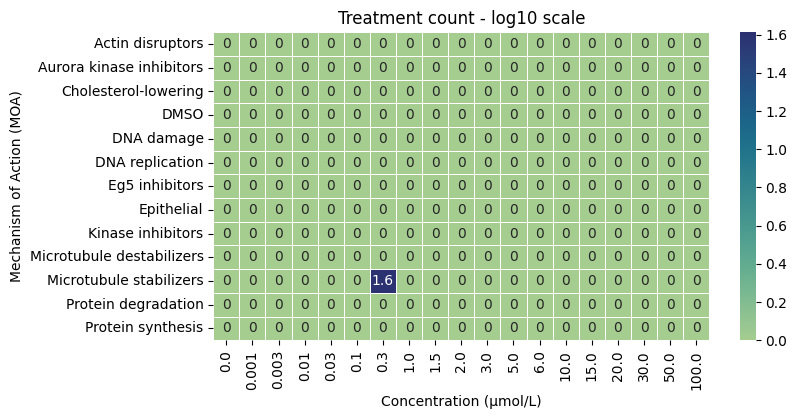

In [107]:
plot_treatment_heatmap(tiny_metadata)

In [108]:
images = normalize_channel_wise(images)
img1 = images[0]

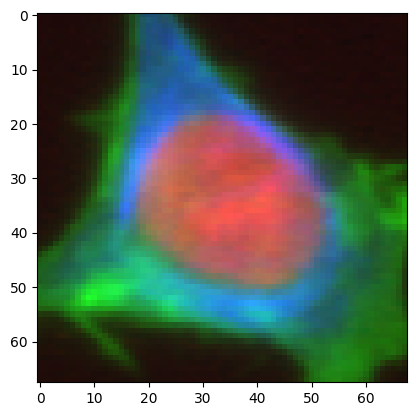

In [109]:
plot_image(img1)

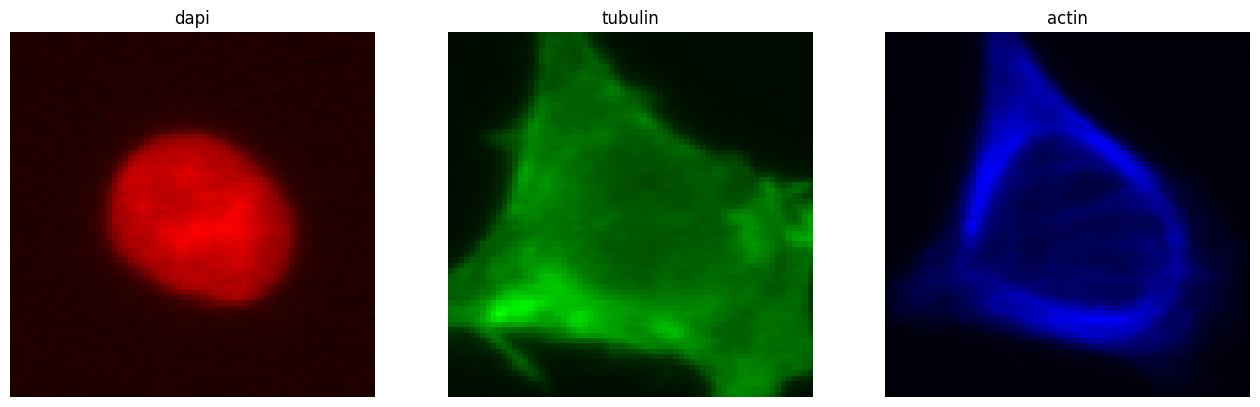

In [110]:
plot_channels(img1)

## Models

In [111]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=3, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [112]:
model = AutoEncoder()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [113]:
training_data = images
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

learning_rate = 1e-2
batch_size = 16
epochs = 300

loss_fn = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    for X in train_dataloader:
        model.train()

        X_reconstruction = model(X)
        loss = loss_fn(X.flatten(), X_reconstruction.flatten())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 68, 68])


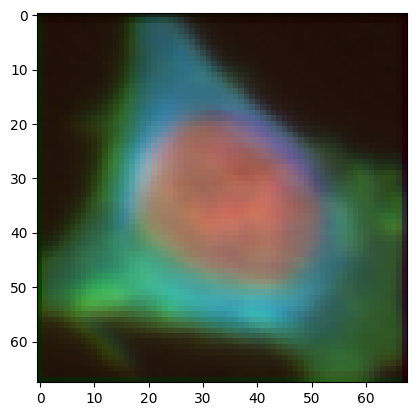

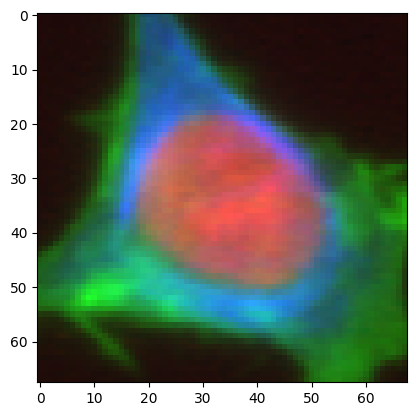

In [114]:
img1_reconstruction = model(img1[None])[0]
print(img1_reconstruction.shape)

plot_image(img1_reconstruction.detach())
plot_image(img1)

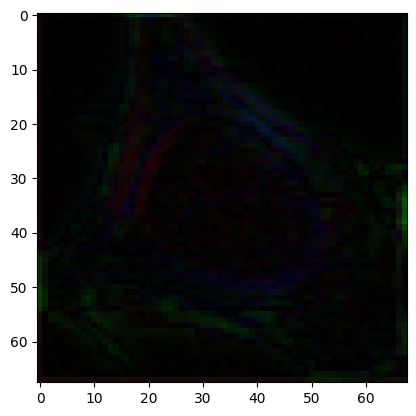

In [98]:
plot_image_diff(img1_reconstruction.detach(), img1)